# Proyek Sistem Rekomendasi

- Author: Faris Nur Rizqiawan
- Platform: Dicoding Submission – Proyek Akhir Machine Learning Terapan
- Domain: Lingkungan
- Metode: Collaborative Filtering (Deep Learning) dan Content-Based Filtering (TF-IDF)

# Instalasi dan Import Library

In [1]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

# Import TensorFlow/Keras secara tunggal
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
tourism_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Model-System-Rekomendasi-Submission-Faris/tourism_jogja.csv")
rating_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Model-System-Rekomendasi-Submission-Faris/tourism_rating.csv")
user_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Model-System-Rekomendasi-Submission-Faris/user.csv")

**insight:**
- tourism_df -> tourism_jogja.csv: Informasi objek wisata
- rating df -> tourism_rating.csv: Rating pengguna terhadap objek wisata
- user_df -> user.csv: Data pengguna


# Exploratory Data Analysis (EDA)

### Cek Informasi Dataset dan Menampilkan Data Teratas

In [11]:
# Data Wisata
tourism_df.info(),
tourism_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   place_id     437 non-null    int64  
 1   name         437 non-null    object 
 2   rating       437 non-null    float64
 3   type         437 non-null    object 
 4   htm          437 non-null    int64  
 5   latitude     437 non-null    object 
 6   longitude    437 non-null    object 
 7   description  437 non-null    object 
dtypes: float64(1), int64(2), object(5)
memory usage: 27.4+ KB


,place_id,name,rating,type,htm,latitude,longitude,description
0,1,Candi Borobudur,4.7,Budaya Dan Sejarah,50000,-7.607.086.854,1.102.036.226,candi yang pernah masuk sebagai salah satu dar...
1,2,Candi Prambanan,4.7,Budaya Dan Sejarah,50000,-7.751.834.561,1.104.915.318,candi prambanan adalah kompleks candi hindu te...
2,3,Tebing Breksi,4.4,Alam,10000,-7.781.476.547,1.105.045.757,tebing breksi merupakan tempat wisata yang ber...
3,4,Gembira Loka Zoo,4.5,Buatan,25000,-78.062.344,1.103.967.977,gambira loka adalah kebun binatang yang berada...
4,5,The Palace of Yogyakarta (Keraton Yogyakarta),4.6,Budaya Dan Sejarah,8000,-78.052.845,1.103.642.031,kompleks keraton merupakan museum yang menyimp...


In [12]:
# Data Rating
rating_df.info(),
rating_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [13]:
# Data User
user_df.info(),
user_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


### Cek Missing Value



In [14]:
# Data Wisata
tourism_df.isnull().sum()

,0
place_id,0
name,0
rating,0
type,0
htm,0
latitude,0
longitude,0
description,0


In [15]:
# Data Rating
rating_df.isnull().sum()

,0
User_Id,0
Place_Id,0
Place_Ratings,0


In [16]:
# Data User
user_df.isnull().sum()

,0
User_Id,0
Location,0
Age,0


### Visualisasi Data

#### Distribusi Tempat Wisata Jogja

<ipython-input-17-d3019e334b46>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=tourism_df, y='type', order=type_counts.index, palette='viridis')


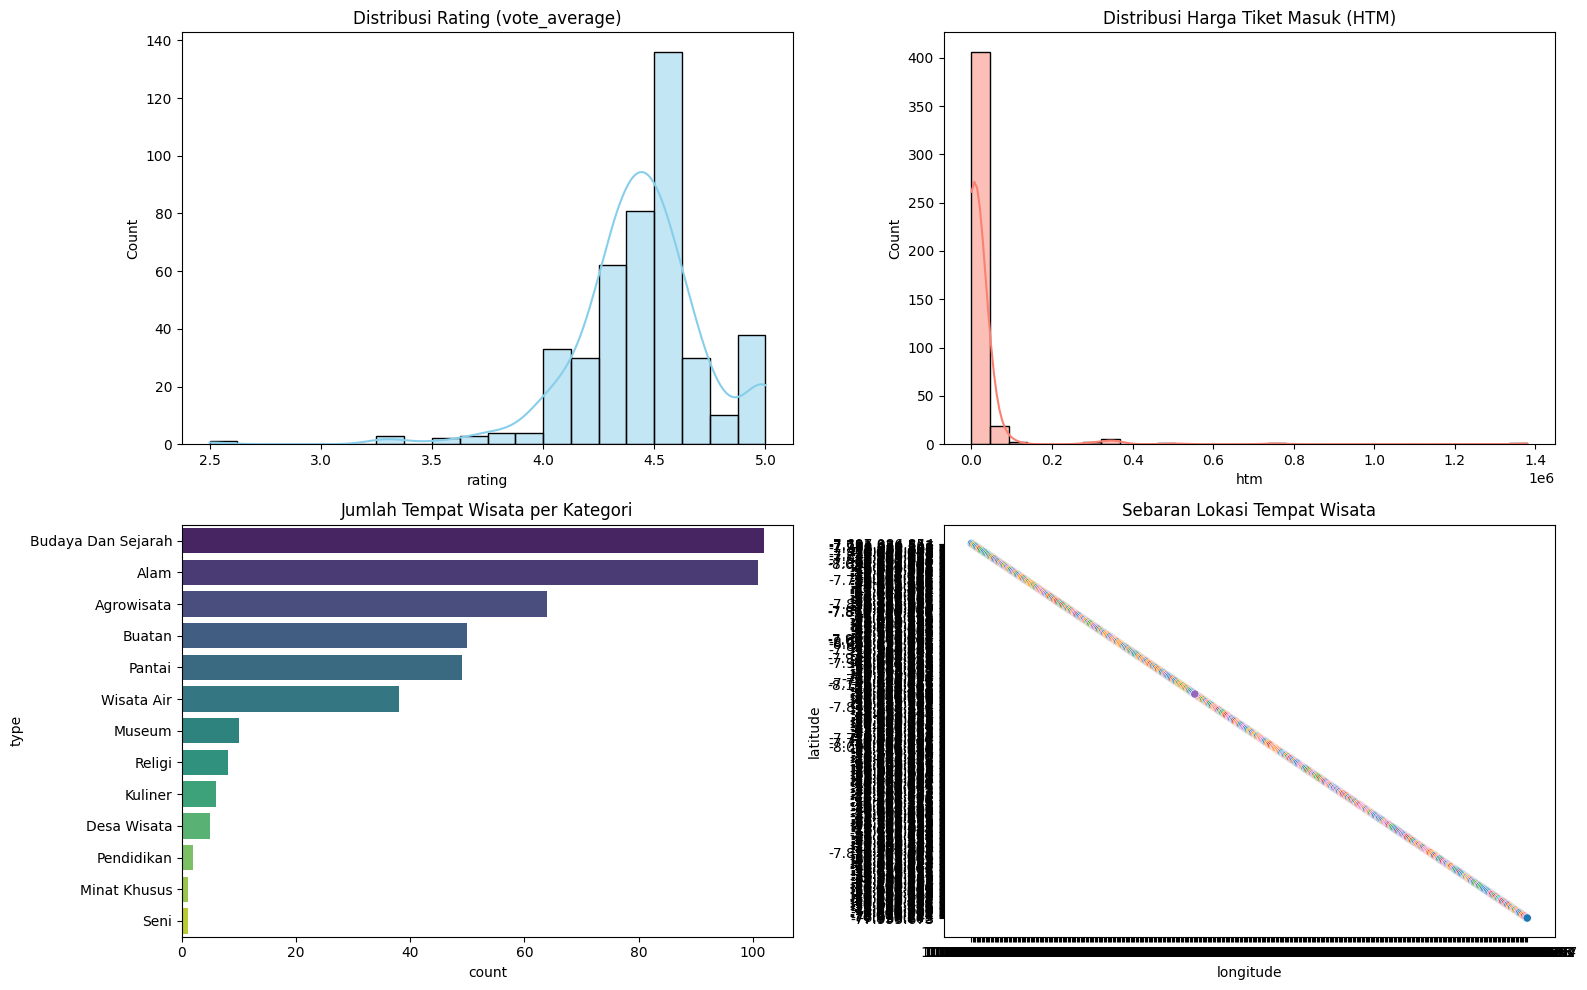

In [17]:
# Distribution of 'type'
type_counts = tourism_df['type'].value_counts()

# Plotting
plt.figure(figsize=(16, 10))

# 1. Distribution of vote_average
plt.subplot(2, 2, 1)
sns.histplot(tourism_df['rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribusi Rating (vote_average)')

# 2. Distribution of htm
plt.subplot(2, 2, 2)
sns.histplot(tourism_df['htm'], bins=30, kde=True, color='salmon')
plt.title('Distribusi Harga Tiket Masuk (HTM)')

# 3. Count of each tourism_df type
plt.subplot(2, 2, 3)
sns.countplot(data=tourism_df, y='type', order=type_counts.index, palette='viridis')
plt.title('Jumlah Tempat Wisata per Kategori')

# 4. Map of tourism_df locations (scatter by lat/lon)
plt.subplot(2, 2, 4)
sns.scatterplot(x='longitude', y='latitude', hue='type', data=tourism_df, palette='tab10', legend=False)
plt.title('Sebaran Lokasi Tempat Wisata')

plt.tight_layout()
plt.show()

**Insight**:

Hasil visualisasi memberikan pemahaman tentang distribusi rating, harga, jenis wisata, dan sebaran geografis tempat wisata. Ini penting untuk menyusun sistem rekomendasi yang mempertimbangkan preferensi dan keterjangkauan pengguna.


#### Distribusi Rating Wisata

<ipython-input-18-4f4ff15eac42>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Place_Ratings', data=rating, palette='Set2')
<ipython-input-18-4f4ff15eac42>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rated_places.values, y=top_rated_places.index, palette='mako')


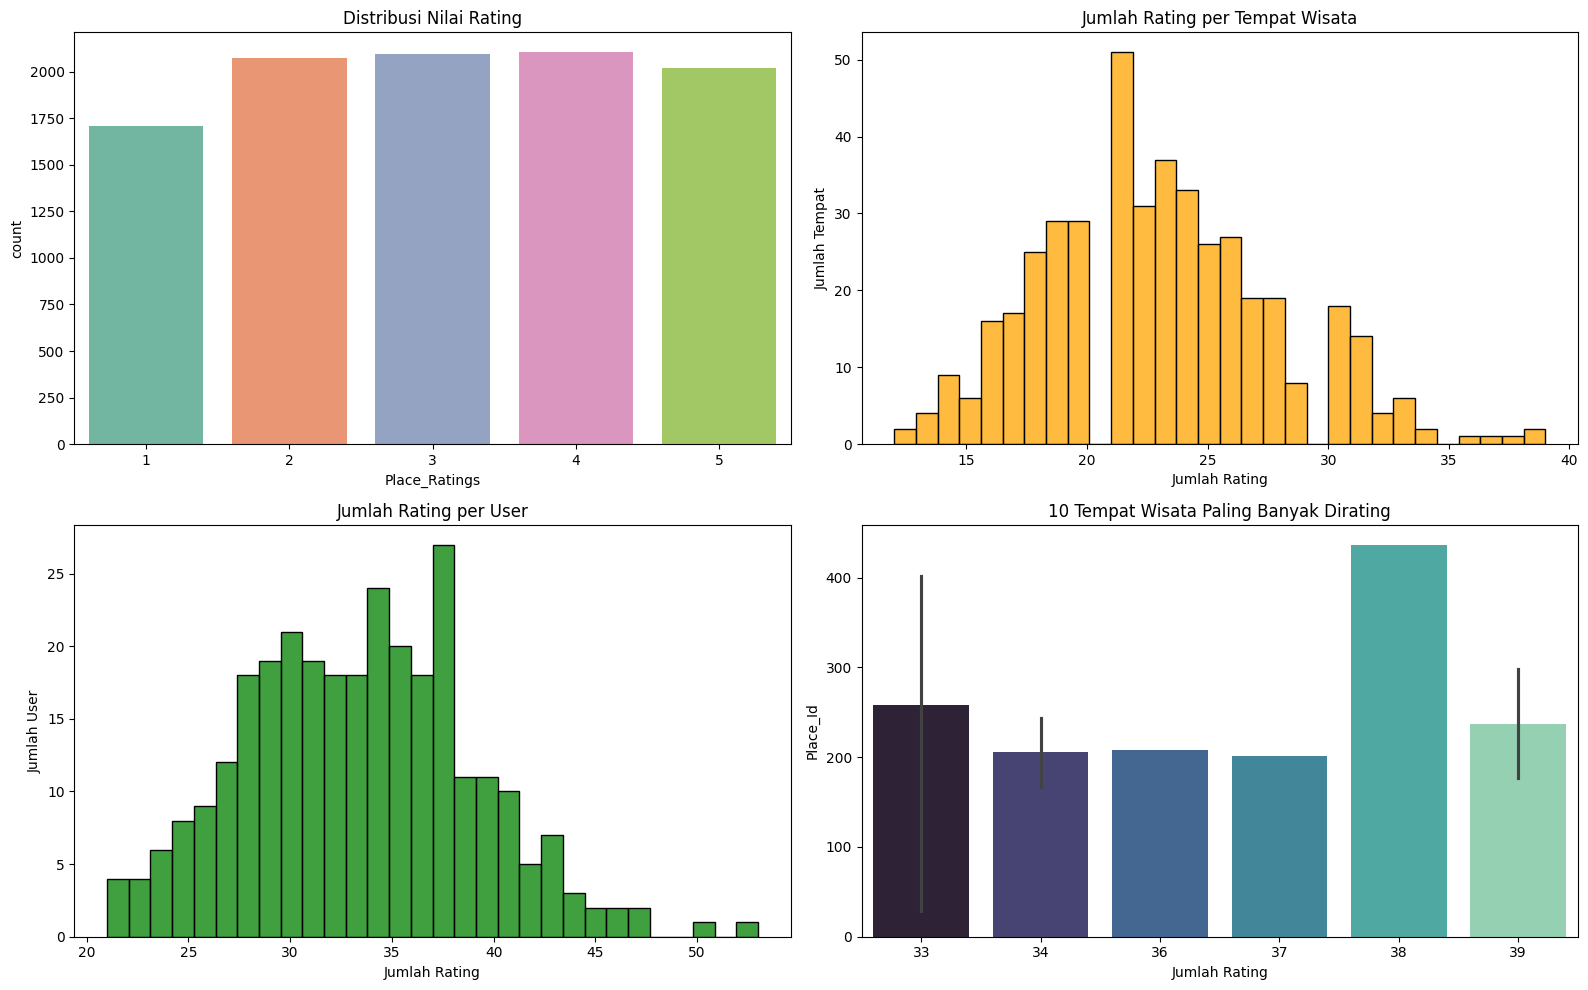

In [18]:
# Copy rating data
rating = rating_df.copy()

# Grouping
ratings_per_place = rating.groupby('Place_Id')['Place_Ratings'].count().sort_values(ascending=False)
ratings_per_user = rating.groupby('User_Id')['Place_Ratings'].count().sort_values(ascending=False)
rating_distribution = rating['Place_Ratings'].value_counts().sort_index()

# Basic stats
rating_stats = rating['Place_Ratings'].describe()

# Plotting
plt.figure(figsize=(16, 10))

# 1. Distribution of ratings
plt.subplot(2, 2, 1)
sns.countplot(x='Place_Ratings', data=rating, palette='Set2')
plt.title('Distribusi Nilai Rating')

# 2. Number of ratings per place
plt.subplot(2, 2, 2)
sns.histplot(ratings_per_place, bins=30, kde=False, color='orange')
plt.title('Jumlah Rating per Tempat Wisata')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah Tempat')

# 3. Number of ratings per user
plt.subplot(2, 2, 3)
sns.histplot(ratings_per_user, bins=30, kde=False, color='green')
plt.title('Jumlah Rating per User')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah User')

# 4. Top 10 most rated places
top_rated_places = ratings_per_place.head(10)
plt.subplot(2, 2, 4)
sns.barplot(x=top_rated_places.values, y=top_rated_places.index, palette='mako')
plt.title('10 Tempat Wisata Paling Banyak Dirating')
plt.xlabel('Jumlah Rating')

plt.tight_layout()
plt.show()

**Insight:**

Distribusi rating pengguna cukup merata dengan kecenderungan nilai sedang hingga tinggi. Tempat dengan jumlah rating tertinggi dapat menjadi acuan rekomendasi populer atau baseline rekomendasi bagi pengguna baru.


#### Distribusi User / Pengguna Wisata

<ipython-input-19-e24542660d93>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_counts.values, y=location_counts.index, palette='pastel')


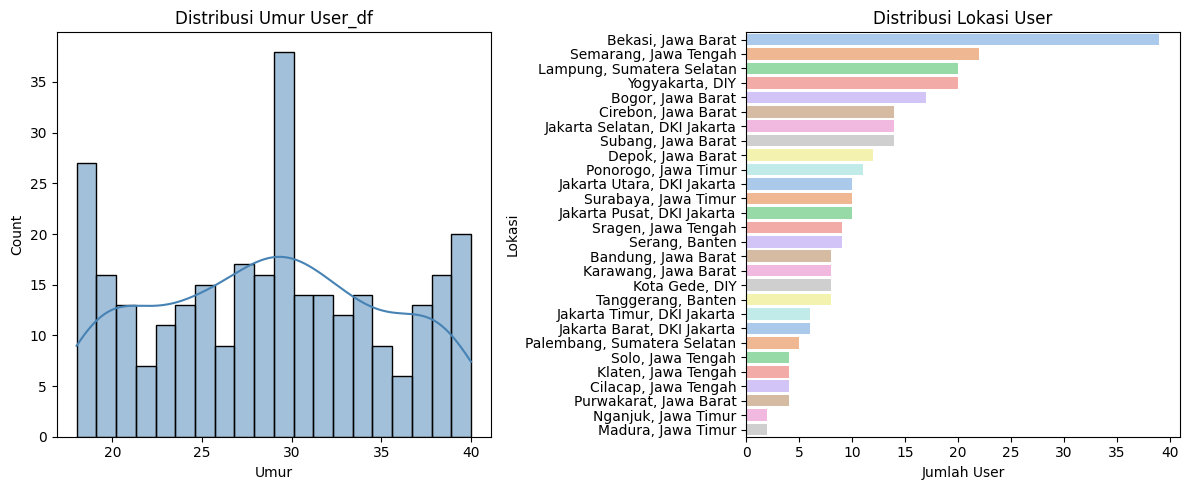

In [19]:
# Visualisasi distribusi umur dan jenis kelamin
plt.figure(figsize=(12, 5))

# 1. Distribusi umur
plt.subplot(1, 2, 1)
sns.histplot(user_df['Age'], bins=20, kde=True, color='steelblue')
plt.title('Distribusi Umur User_df')
plt.xlabel('Umur')

# 2. Distribusi lokasi (Modified part)
plt.subplot(1, 2, 2)
# Get the count of each location and plot it
location_counts = user_df['Location'].value_counts()
sns.barplot(x=location_counts.values, y=location_counts.index, palette='pastel')
plt.title('Distribusi Lokasi User')
plt.xlabel('Jumlah User')
plt.ylabel('Lokasi')


plt.tight_layout()
plt.show()

**Insight:**

Grafik diatas memaparkan demografi pengguna wisata yang meliputi usia dan keberadaan asal pengguna. Informasi ini berguna untuk menyesuaikan sistem rekomendasi agar lebih relevan terhadap kelompok demografi utama yang menggunakan aplikasi.


#### Korelasi Rating User

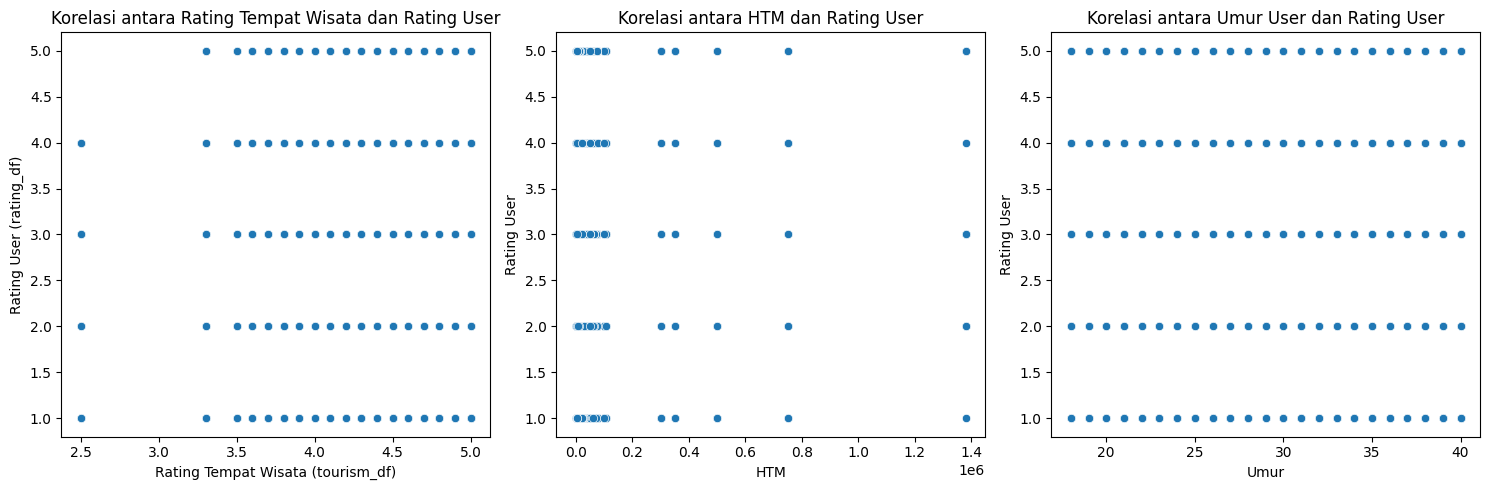

In [20]:
# Merge rating_df with tourism_df on Place_Id
merged_rating_tourism = pd.merge(rating_df, tourism_df, left_on='Place_Id', right_on='place_id', how='inner')

# Merge the result with user_df on User_Id
merged_data = pd.merge(merged_rating_tourism, user_df, left_on='User_Id', right_on='User_Id', how='inner')

# Visualisasi Korelasi
plt.figure(figsize=(15, 5))

# Correlation between Place_Ratings and tourism_df rating
plt.subplot(1, 3, 1)
sns.scatterplot(x='rating', y='Place_Ratings', data=merged_data)
plt.title('Korelasi antara Rating Tempat Wisata dan Rating User')
plt.xlabel('Rating Tempat Wisata (tourism_df)')
plt.ylabel('Rating User (rating_df)')

# Correlation between Place_Ratings and htm
plt.subplot(1, 3, 2)
sns.scatterplot(x='htm', y='Place_Ratings', data=merged_data)
plt.title('Korelasi antara HTM dan Rating User')
plt.xlabel('HTM')
plt.ylabel('Rating User')

# Correlation between Place_Ratings and Age
plt.subplot(1, 3, 3)
sns.scatterplot(x='Age', y='Place_Ratings', data=merged_data)
plt.title('Korelasi antara Umur User dan Rating User')
plt.xlabel('Umur')
plt.ylabel('Rating User')

plt.tight_layout()
plt.show()

**Insight:** <br>
Berdasarkan grafik korelasi:
- Tidak ada korelasi kuat antara rating tempat wisata dengan rating user.
- Harga tiket masuk (HTM) tidak terlalu mempengaruhi rating user.
- Usia pengguna juga tidak menunjukkan tren yang konsisten dalam pemberian rating.

# Modeling Content-Based Filtering

### Pre Processing TF-IDF Vectorization

In [21]:
# Salin dataframe tempat wisata
tourism_df_pre = tourism_df.copy()

# Buat daftar stopwords Indonesia dari Sastrawi
factory = StopWordRemoverFactory()
stop_words = factory.get_stop_words()

# Inisialisasi TF-IDF Vectorizer dengan stopwords dari Sastrawi
tfidf = TfidfVectorizer(stop_words=stop_words, max_features=500)

# TF-IDF dan cosine similarity seperti sebelumnya
tfidf_matrix = tfidf.fit_transform(tourism_df_pre['description'])
tfidf_matrix.shape

(437, 500)

**Insight:**

- Deskripsi tempat wisata dikonversi ke bentuk numerik menggunakan TF-IDF dengan 500 fitur, setelah menghapus stopwords Bahasa Indonesia.
- Hasilnya berupa matriks TF-IDF yang siap digunakan untuk menghitung kemiripan antar tempat wisata.

### Modelling dan Rekomendasi

In [22]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.17721715, 0.1008    , ..., 0.        , 0.        ,
        0.        ],
       [0.17721715, 1.        , 0.12427941, ..., 0.        , 0.        ,
        0.        ],
       [0.1008    , 0.12427941, 1.        , ..., 0.        , 0.09390163,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.17212102,
        0.        ],
       [0.        , 0.        , 0.09390163, ..., 0.17212102, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

**Insight:**
- Matriks cosine similarity dihitung dari TF-IDF untuk mengukur tingkat kemiripan antar deskripsi tempat wisata.

In [23]:
cosine_sim_df = pd.DataFrame(
    cosine_sim, index=tourism_df.name, columns=tourism_df.name)
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(10, axis=0)

Shape: (437, 437)


name,Candi Borobudur,Candi Prambanan,Tebing Breksi,Gembira Loka Zoo,The Palace of Yogyakarta (Keraton Yogyakarta),Taman Sari,Hutan Pinus Mangunan Dlingo,Jogja Bay,The World Landmarks - Merapi Park Yogyakarta,The Lost World Castle,...,JOLLY ROGER TATTOO,Jurang Tembelan Kreen,Lawang Ijo,Monumen Deles Indah,Monumen Serang Umum 1 Maret,Museum Pendidikan dan Mainan Kolong Tangga,Nggunungan,"Pancuran ""Tirip Kulon""",Sasana Tirta Kembaran,Sokkel klok voor Eeuw Nederlandsch-Indische
name,,,,,,,,,,,,,,,,,,,,,
Goa Sentono,0.000000,0.000000,0.000000,0.000000,0.038508,0.000000,0.000000,0.025185,0.000000,0.041900,...,0.000000,0.093078,0.000000,0.055528,0.000000,0.000000,0.048895,0.105281,0.0,0.000000
Pintoe Langit Dahromo,0.000000,0.012541,0.032889,0.044504,0.066958,0.012127,0.042784,0.038628,0.104392,0.279712,...,0.085654,0.093145,0.126523,0.000000,0.000000,0.067631,0.000000,0.000000,0.0,0.000000
Wisata Pangol Hill,0.000000,0.000000,0.012602,0.000000,0.000000,0.018864,0.015911,0.019251,0.010562,0.018204,...,0.000000,0.064825,0.134045,0.077345,0.000000,0.000000,0.465800,0.000000,0.0,0.000000
Taman Lampion Candi Plaosan,0.000000,0.000000,0.000000,0.000000,0.000000,0.136362,0.000000,0.000000,0.122155,0.097017,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058289,0.000000,0.0,0.000000
Museum Sonobudoyo Unit I,0.000000,0.012934,0.050576,0.029878,0.364792,0.133164,0.020756,0.033477,0.000000,0.023748,...,0.118273,0.000000,0.000000,0.000000,0.000000,0.354292,0.000000,0.045900,0.0,0.000000
Puncak watu wayang,0.000000,0.000000,0.000000,0.000000,0.000000,0.025064,0.042281,0.000000,0.000000,0.000000,...,0.059341,0.145492,0.000000,0.107802,0.000000,0.000000,0.094926,0.000000,0.0,0.000000
Candi Kelir,0.106407,0.092837,0.063862,0.018801,0.051879,0.030424,0.093448,0.031048,0.102091,0.137498,...,0.000000,0.046373,0.063949,0.143389,0.123116,0.000000,0.000000,0.000000,0.0,0.178997
Jogja Exotarium,0.000000,0.000000,0.068991,0.246416,0.037798,0.077983,0.093454,0.092857,0.101991,0.130622,...,0.048351,0.060273,0.034778,0.000000,0.000000,0.082060,0.000000,0.000000,0.0,0.027104
Patung Monyet Kaliurang,0.069249,0.000000,0.030104,0.184262,0.060198,0.129472,0.061005,0.092656,0.073071,0.000000,...,0.000000,0.045574,0.323049,0.083737,0.000000,0.000000,0.073735,0.000000,0.0,0.048980


**Insight:**
- Dibuat DataFrame kemiripan antar tempat wisata berdasarkan nama, sehingga memudahkan pencarian tempat yang mirip satu sama lain.

In [24]:
# Fungsi rekomendasi
def recommend_places_content_based(place_name, top_n=5):
    if place_name not in tourism_df['name'].values:
        return f"Tempat '{place_name}' tidak ditemukan dalam data."

    idx = tourism_df[tourism_df['name'] == place_name].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    place_indices = [i[0] for i in sim_scores]
    return tourism_df.iloc[place_indices][['name', 'type', 'rating', 'htm', 'description']]

# Contoh penggunaan
recommend_places_content_based("Candi Borobudur", top_n=10)

,name,type,rating,htm,description
119,Candi Sari,Budaya Dan Sejarah,4.5,2000,candi sari juga disebut candi bendah adalah ca...
108,Candi Banyunibo,Budaya Dan Sejarah,4.5,5000,candi banyunibo adalah candi buddha yang berad...
100,Candi Kalasan,Budaya Dan Sejarah,4.5,5000,candi kalasan adalah candi yang dipersembahkan...
60,Candi Sewu,Budaya Dan Sejarah,4.6,10000,candi sewu adalah candi buddha yang dibangun p...
76,Candi Sojiwan,Budaya Dan Sejarah,4.5,5000,candi sojiwan memiliki keunikan keunikan ini b...
28,Candi Plaosan,Budaya Dan Sejarah,4.6,3000,candi plaosan terletak di desa bugisan kecamat...
383,Candi Plaosan Lor,Budaya Dan Sejarah,4.2,3000,kompleks candi buddha yang megah dengan arsite...
230,Candi Ijo,Budaya Dan Sejarah,4.7,10000,candi ijo adalah sebuah kompleks percandian be...
287,Perwara Temple,Budaya Dan Sejarah,4.4,50000,candi candi pendamping di kompleks prambanan y...
114,Candi Abang,Budaya Dan Sejarah,4.2,5000,candi abang memiliki bentuk seperti piramida d...


Insight:
- Fungsi rekomendasi tempat wisata berdasarkan kemiripan deskripsi menggunakan Content-based Filtering.
- Fungsi mengembalikan daftar tempat wisata paling mirip dengan input berdasarkan nilai cosine similarity.

# Modeling Collaborative Filtering

### Pre Processing Encoding

In [25]:
# Gabungkan data rating, user, dan tempat wisata
cf_df = rating_df.merge(user_df, on='User_Id').merge(tourism_df[['place_id', 'name']], left_on='Place_Id', right_on='place_id')

# Lakukan label encoding untuk user dan tempat wisata
user_encoder = LabelEncoder()
place_encoder = LabelEncoder()
cf_df['user_enc'] = user_encoder.fit_transform(cf_df['User_Id'])
cf_df['place_enc'] = place_encoder.fit_transform(cf_df['place_id'])

# Simpan mapping asli untuk keperluan inferensi
user_id_map = dict(zip(cf_df['User_Id'], cf_df['user_enc']))
place_id_map = dict(zip(cf_df['place_id'], cf_df['place_enc']))

# Tampilkan contoh hasil encoding
cf_df[['User_Id', 'user_enc', 'place_id', 'place_enc', 'Place_Ratings']].head()


,User_Id,user_enc,place_id,place_enc,Place_Ratings
0,1,0,179,178,3
1,1,0,344,343,2
2,1,0,5,4,5
3,1,0,373,372,3
4,1,0,101,100,4


**Insight:**
- Data rating digabung dengan informasi user dan tempat wisata, lalu dilakukan label encoding untuk mengubah ID user dan tempat ke format numerik agar bisa digunakan dalam model.
- Mapping asli disimpan untuk kebutuhan interpretasi hasil rekomendasi nanti.

### Modelling dan Rekomendasi

In [26]:
# Fitur dan label
X = cf_df[['user_enc', 'place_enc']].values
y = cf_df['Place_Ratings'].values

# Split ke training dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
# Definisikan kembali RecommenderNet jika belum
class RecommenderNet(Model):
    def __init__(self, num_users, num_places, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(num_users, embedding_size, embeddings_initializer='he_normal')
        self.user_bias = layers.Embedding(num_users, 1)
        self.place_embedding = layers.Embedding(num_places, embedding_size, embeddings_initializer='he_normal')
        self.place_bias = layers.Embedding(num_places, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        place_vector = self.place_embedding(inputs[:, 1])
        place_bias = self.place_bias(inputs[:, 1])
        dot_product = tf.reduce_sum(user_vector * place_vector, axis=1, keepdims=True)
        return dot_product + user_bias + place_bias


In [28]:
# Inisialisasi dan Kompilasi Model
num_users = cf_df['user_enc'].nunique()
num_places = cf_df['place_enc'].nunique()

model = RecommenderNet(num_users, num_places)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Insight:
- Dibuat model rekomendasi menggunakan neural network dengan embedding untuk user dan tempat wisata guna menangkap preferensi laten.
- Model menghitung interaksi user dan tempat dengan dot product ditambah bias khusus user dan tempat.
- Model dikompilasi menggunakan optimizer Adam dan loss MSE untuk prediksi rating numerik

In [29]:
# Train
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=1,
)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 11.1992 - mae: 3.0487 - val_loss: 10.5181 - val_mae: 2.9370
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.4674 - mae: 2.9293 - val_loss: 9.9675 - val_mae: 2.8419
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.7243 - mae: 2.7951 - val_loss: 9.4159 - val_mae: 2.7435
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.2039 - mae: 2.7133 - val_loss: 8.8234 - val_mae: 2.6335
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.3688 - mae: 2.5541 - val_loss: 8.1123 - val_mae: 2.4949
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.4437 - mae: 2.3818 - val_loss: 7.1845 - val_mae: 2.3020
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.2184 - mae: 2.1233 - val_loss: 6.0089 - val_mae: 2.0539
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.8894 - mae: 1.8397 - val_loss: 4.7119 - val_mae: 1.7922
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step -

In [30]:
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, MAE: {mae:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1914 - mae: 1.2360
Test Loss: 2.2548, MAE: 1.2559


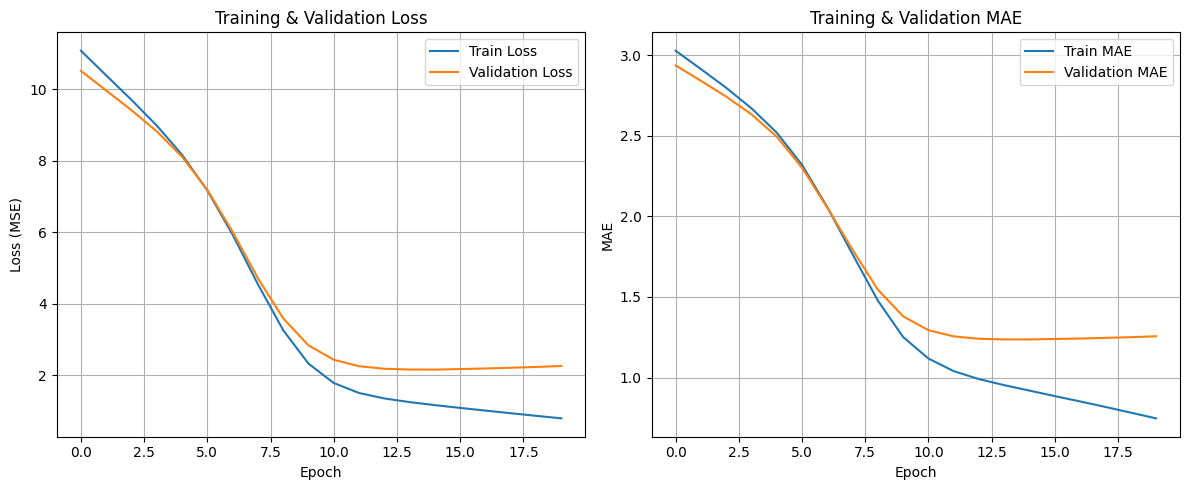

In [31]:
# Visualisasi Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Visualisasi MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training & Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [32]:
# Buat reverse mapping dari encoded ke id asli
reverse_place_map = {v: k for k, v in place_id_map.items()}

def recommend_top_n(user_id, n=5):
    user_idx = user_id_map.get(user_id)
    if user_idx is None:
        print("User tidak ditemukan.")
        return pd.DataFrame()

    # Ambil semua encoded tempat wisata
    all_places = np.arange(num_places)

    # Buat input (user, place) untuk prediksi
    user_input = np.array([[user_idx, place_id] for place_id in all_places])

    # Prediksi rating
    predicted_ratings = model.predict(user_input).flatten()

    # Ambil top-N rekomendasi
    top_indices = predicted_ratings.argsort()[::-1][:n]
    top_place_enc = all_places[top_indices]
    top_place_ids = [reverse_place_map[enc] for enc in top_place_enc]

    # Ambil info tempat dari tourism_df, sekarang termasuk htm dan deskripsi
    recommendations = tourism_df[
        tourism_df['place_id'].isin(top_place_ids)
    ][['place_id', 'name', 'type', 'rating', 'htm', 'description']]

    # Tambahkan skor prediksi ke dalam hasil rekomendasi
    recommendations = recommendations.copy()
    recommendations['predicted_rating'] = [
        predicted_ratings[all_places.tolist().index(place_encoder.transform([pid])[0])] for pid in recommendations['place_id']
    ]

    # Urutkan hasil akhir berdasarkan skor prediksi tertinggi
    recommendations = recommendations.sort_values(by='predicted_rating', ascending=False).reset_index(drop=True)

    return recommendations[['name', 'type', 'rating', 'htm', 'description']]


**Insight:**
- Fungsi merekomendasikan top-N destinasi wisata berdasarkan prediksi rating model untuk user tertentu, menggunakan kombinasi semua tempat dan ID user.
- Hasil rekomendasi disusun berdasarkan skor prediksi tertinggi dan diperkaya dengan informasi tempat dari tourism_df.

In [33]:
recommend_top_n(user_id=1, n=10)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


,name,type,rating,htm,description
0,Gua Jepang,Alam,4.1,10000,gua peninggalan tentara jepang di masa perang ...
1,Pantai Ngrumput,Pantai,4.6,10000,pantai ngrumput memang kalah pamor dengan para...
2,Vegetalika Faperta UGM,Pendidikan,4.3,0,kebun edukatif milik fakultas pertanian ugm ya...
3,Bukit white stone,Alam,5.0,15000,bukit dengan formasi batu kapur putih yang uni...
4,Selopamioro Adventure Park,Alam,4.5,30000,kegiatan outbond di lokasi selopamioro adventu...
5,Watu Payung,Alam,4.4,0,watu payung adalah destinasi alam yang menawar...
6,Candi Sumberwatu,Budaya Dan Sejarah,3.3,0,situs candi kecil yang menawarkan panorama ala...
7,The Palace of Yogyakarta (Keraton Yogyakarta),Budaya Dan Sejarah,4.6,8000,kompleks keraton merupakan museum yang menyimp...
8,Wisata Watu Amben,Alam,4.5,5000,terletak di kawasan bukit bintang watu amben a...
9,Bukit Lintang Sewu,Alam,4.5,3000,bukit lintang sewu merupakan salah satu tempat...


# Kesimpulan:

1. Content-Based Filtering: Model Content-Based Filtering berhasil dibangun untuk merekomendasikan tempat wisata Jogja berdasarkan kemiripan deskripsi.
2. Collaborative Filtering: Model Collaborative Filtering dilatih dan dievaluasi. Evaluasi model menunjukkan kinerja yang baik dengan nilai MAE sebesar 1.2559, membuktikan efektivitasnya dalam menangkap preferensi user.

Berdasarkan kedua model tersebut, rekomendasi wisata Jogja dapat dihasilkan, menampilkan nama tempat, tipe, rating, HTM, dan deskripsi untuk membantu user dalam memilih destinasi.